In [1]:
import fastai
from fastai import *          # Quick access to most common functionality
from fastai.vision import *   # Quick access to computer vision functionality
from fastai.layers import Lambda
from fastai.callbacks import *
import pytorch_ssim as ssim
from superres import *
from torchvision.models import vgg16_bn
import czifile
import shutil
import numbers
from fastai.vision.image import TfmPixel
import PIL
import torch
import torchvision as vision

In [2]:
import superres.rddb as rddb

In [3]:
# , "norm_type": null
#     , "mode": "CNA"
#     , "nf": 64
#     , "nb": 23
#     , "in_nc": 3
#     , "out_nc": 3
#     , "gc": 32
# , "group": 1

#model = rddb.RRDB_Net(in_nc=1,out_nc=1,nf=64,nb=23, upscale=4)

In [38]:
PATH = Path('/DATA/WAMRI/salk/uri/movies')
movie_path = PATH/'movie_src'
test_path = PATH/'movie_test'
train_src = movie_path/'train'
valid_src = movie_path/'valid'
#Following are separated folders
TEMP_DATA = Path('/DATA/WAMRI/salk/uri/movies/')
train_hr = TEMP_DATA/'train_hr'
train_lr = TEMP_DATA/'train_lr'
train_hr_ROI = TEMP_DATA/'train_hr_ROI'
train_lr_ROI = TEMP_DATA/'train_lr_ROI'
valid_hr = TEMP_DATA/'valid_hr'
valid_lr = TEMP_DATA/'valid_lr'
valid_hr_ROI = TEMP_DATA/'valid_hr_ROI'
valid_lr_ROI = TEMP_DATA/'valid_lr_ROI'
path_models = Path('/DATA/WAMRI/salk/uri/models')

# for folder in [train_hr, train_lr, valid_hr, valid_lr, train_hr_ROI, train_lr_ROI, valid_hr_ROI, valid_lr_ROI]:
#     if folder.exists(): shutil.rmtree(folder)

In [41]:
def process_czi(czi_fn, hr_dir, lr_dir, hr_ROI_dir, lr_ROI_dir,hr_size=256):
    with czifile.CziFile(czi_fn) as czi_f:
        proc_axes, proc_shape = get_czi_shape_info(czi_f)
        channels = proc_shape['C'] 
        depths = proc_shape['Z']
        times = proc_shape['T']
        x,y = proc_shape['X'], proc_shape['Y']
        data = czi_f.asarray()
        for channel in range(channels):
            for depth in range(depths):
                for time_col in range(times):
                    idx = build_index(proc_axes, {'T': time_col, 'C': channel, 'Z':depth, 'X':slice(0,x),'Y':slice(0,y)})
                    img = data[idx].astype(np.float)
                    img -= img.min()
                    img /= img.max()
                    save_fn = hr_dir/f'{czi_fn.stem}_{channel:02d}_{depth:03d}_{time_col:03d}.tif'
                    
                    pimg = PIL.Image.fromarray((img*255).astype(np.uint8), mode='L')
                    pimg.save(save_fn)
                    
                    cur_size = pimg.size
                    new_size = (cur_size[0]//4, cur_size[1]//4)
                    pimg.resize(new_size, resample=PIL.Image.BICUBIC).save(lr_dir/save_fn.name)
                    
                    img = PIL.Image.open(save_fn)
                    rc = vision.transforms.RandomCrop([hr_size, hr_size])
                    sample_num = 5
                    count = 0
                        #pass in 25 sub ROIS drawn randomly from img and save them 
                        #(and its downsampled counterpart) to disk (similar to below)
                        #another for loop for samples (keep drawing ROIs and check until saving 5 samples to disk)
                        # - generate tiles (get it work first)
                        # - check tiles
                    while count < 10:
                        save_fn = hr_ROI_dir/f'{czi_fn.stem}_{channel:02d}_{depth:03d}_{time_col:03d}_{count:02d}.tif' #add sample number.
                        ROI = rc(img)
                        ROI_stats = PIL.ImageStat.Stat(ROI)
                        if ROI_stats.stddev[0]>10:
                            count = count+1
                            ROI.save(save_fn)
                            cur_size = ROI.size
                            new_size = (cur_size[0]//4, cur_size[1]//4)
                            ROI.resize(new_size, resample=PIL.Image.BICUBIC).save(lr_ROI_dir/save_fn.name)

In [40]:
if not train_hr.exists():
    for folder in [train_hr, train_lr, valid_hr, valid_lr, train_hr_ROI, train_lr_ROI, valid_hr_ROI, valid_lr_ROI]: 
        folder.mkdir(parents=True,exist_ok=True)
    train_files = list(train_src.glob('*.czi'))
    for fn in progress_bar(train_files): process_czi(fn, train_hr, train_lr, train_hr_ROI, train_lr_ROI)
    valid_files = list(valid_src.glob('*.czi'))
    for fn in progress_bar(valid_files): process_czi(fn, valid_hr, valid_lr, valid_hr_ROI, valid_lr_ROI)

1740 1740 256
1740 1740 256
1740 1740 256
1740 1740 256
1740 1740 256
1740 1740 256
1740 1740 256


1740 1740 256
1740 1740 256
1740 1740 256


In [42]:
train_files = list(train_src.glob('*.czi'))

In [43]:
def match_hr_func(x):
    return Path(str(x).replace('_lr','_hr'))

src = (GrayImageItemList
       .from_folder(TEMP_DATA, '*.tif')
       .split_by_folder(train='train_lr_ROI', valid='valid_lr_ROI')
       .label_from_func(match_hr_func))

In [44]:
x,y = src.train[5]
x.shape, y.shape

(torch.Size([1, 64, 64]), torch.Size([1, 256, 256]))

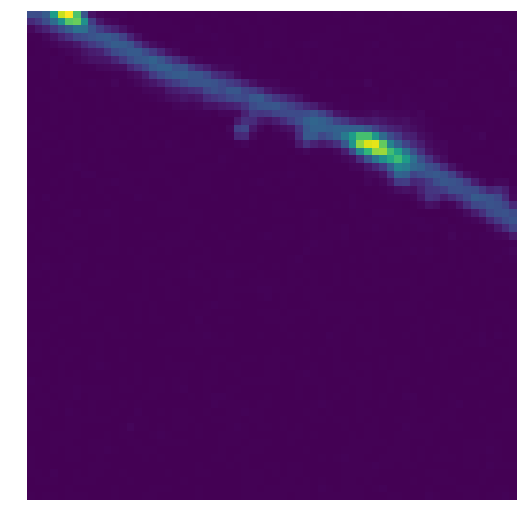

In [45]:
x.show(figsize=(9,9))

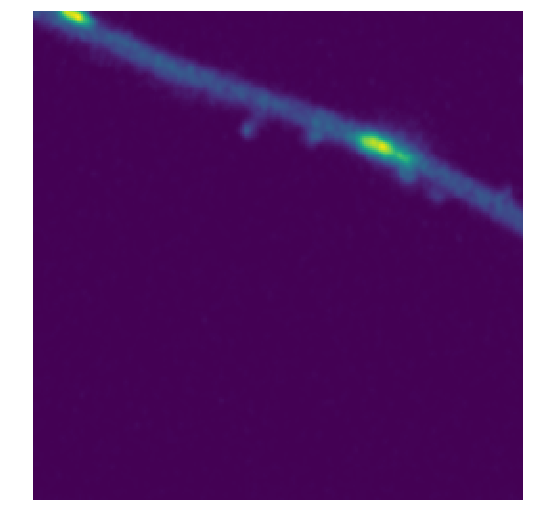

In [46]:
y.show(figsize=(9,9))

In [47]:
bs = 4
sz_lr = src.train.x[0].shape[1]
sz_hr = 4*sz_lr
data = get_data(src, bs, sz_lr, sz_hr)

In [48]:
x,y  = data.train_ds[0]

tensor(0.5843) tensor(0.) tensor(0.6588) tensor(0.)
tensor(0.4353) tensor(0.) tensor(0.4588) tensor(0.)
tensor(0.9373) tensor(0.) tensor(1.) tensor(0.)
tensor(0.9647) tensor(0.) tensor(1.0000) tensor(0.)


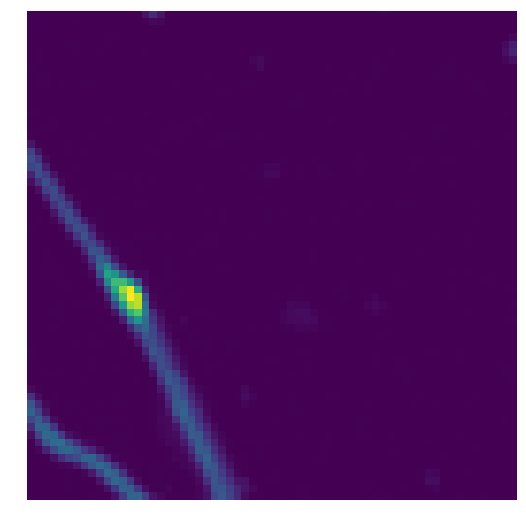

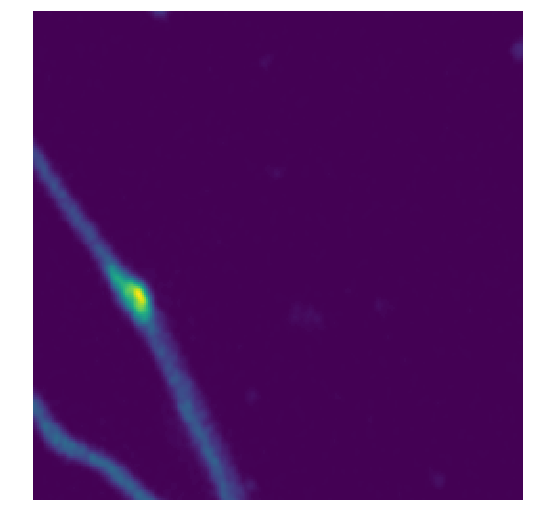

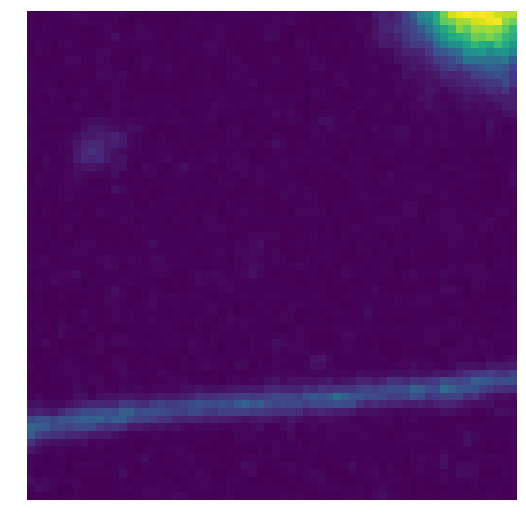

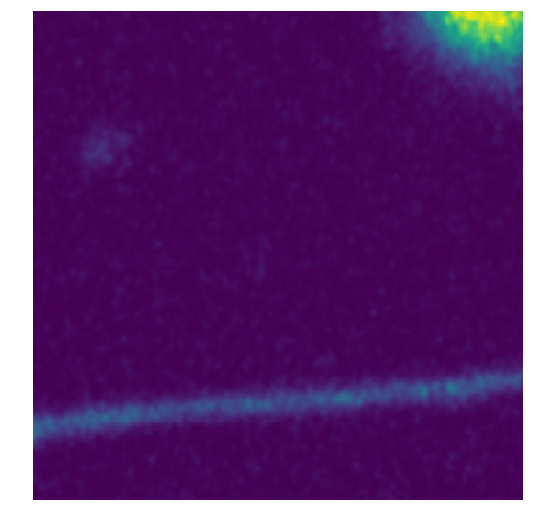

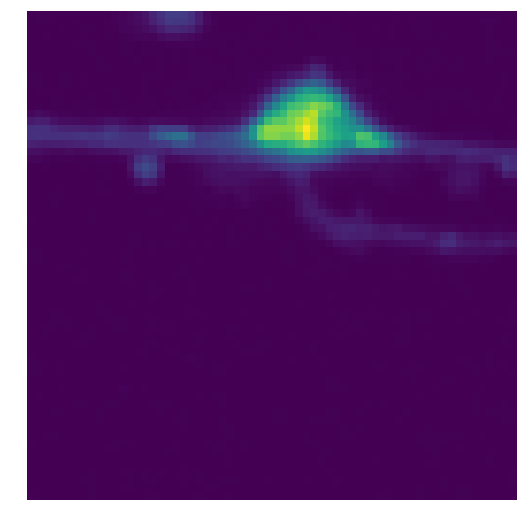

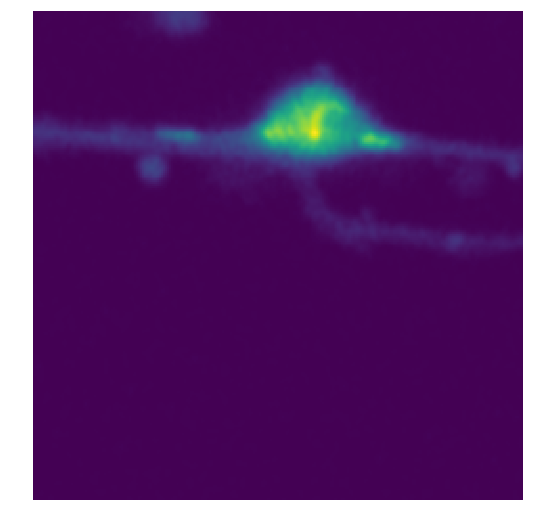

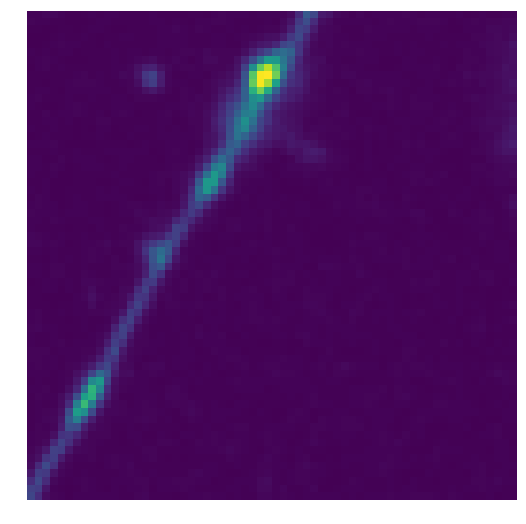

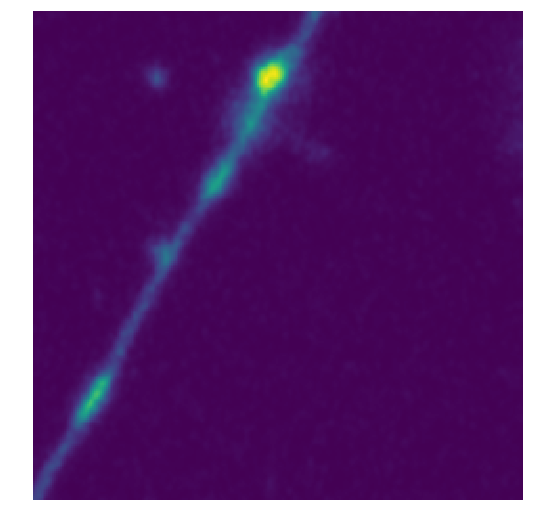

In [49]:
i = 0
for x,y in data.valid_ds:
    x.show(figsize=(9,9)), y.show(figsize=(9,9))
    print(x.data.max(), x.data.min(), y.data.max(), y.data.min())
    if i > 2: break
    i+=1

In [51]:
n_feats = 64
n_res = 12
n_color = 1
scale=4
#model = DBPNLL(num_channels=1, base_filter=32, feat = 256, num_stages=10, scale_factor=scale)
#model = SrResnet(n_feats, n_res, n_color, scale)
model = rddb.RRDB_Net(in_nc=1,out_nc=1,nf=64,nb=23, upscale=4)
model = nn.DataParallel(model, [0,1,2,3])

In [52]:
def charbonnier_loss(inputs, targets):
    eps = 1e-6;
    d = inputs - targets
    e = torch.sqrt(d**2 + eps)
    return e.mean()

#loss = charbonnier_loss
loss = F.mse_loss
#loss = F.l1_loss


In [ ]:
sz_lr = src.train.x[0].shape[1]
scale,bs = 4,16
sz_hr = sz_lr*scale

learn = build_learner(model, bs, sz_lr, sz_hr, src, loss=loss, model_dir=path_models)
learn.lr_find()
learn.recorder.plot()
#learn.data.train_ds[0][0]

epoch,train_loss,valid_loss,mse_loss,ssim,psnr
1,0.007233,0.000484,0.000484,0.630629,33.168472
2,0.002407,0.000182,0.000182,0.865460,37.407074
3,0.001056,0.000142,0.000142,0.867870,38.484146
4,0.000559,0.000140,0.000140,0.803315,38.557255
5,0.000356,0.000134,0.000134,0.835696,38.750137


save: movies_1.0


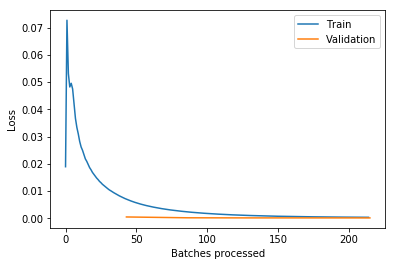

In [53]:
sz_lr = src.train.x[0].shape[1]
scale,bs = 4,16
sz_hr = sz_lr*scale
epochs, lr = 5, 1e-3
learn = batch_learn(model, bs, sz_lr, sz_hr, lr, epochs, src, 
                    save='movies_1.0', 
                    loss=loss, model_dir=path_models)

In [54]:
rows = 2
ds = learn.dl(DatasetType.Valid).dataset

learn.callbacks.append(RecordOnCPU())
preds = learn.pred_batch(DatasetType.Valid)
*learn.callbacks,rec_cpu = learn.callbacks
x,y = rec_cpu.input,rec_cpu.target

In [55]:
xs = [ds.x.reconstruct(x[i]) for i in range(x.shape[0])]
ys = [ds.y.reconstruct(y[i]) for i in range(y.shape[0])]
preds = [ds.y.reconstruct(preds[i]) for i in range(preds.shape[0])]

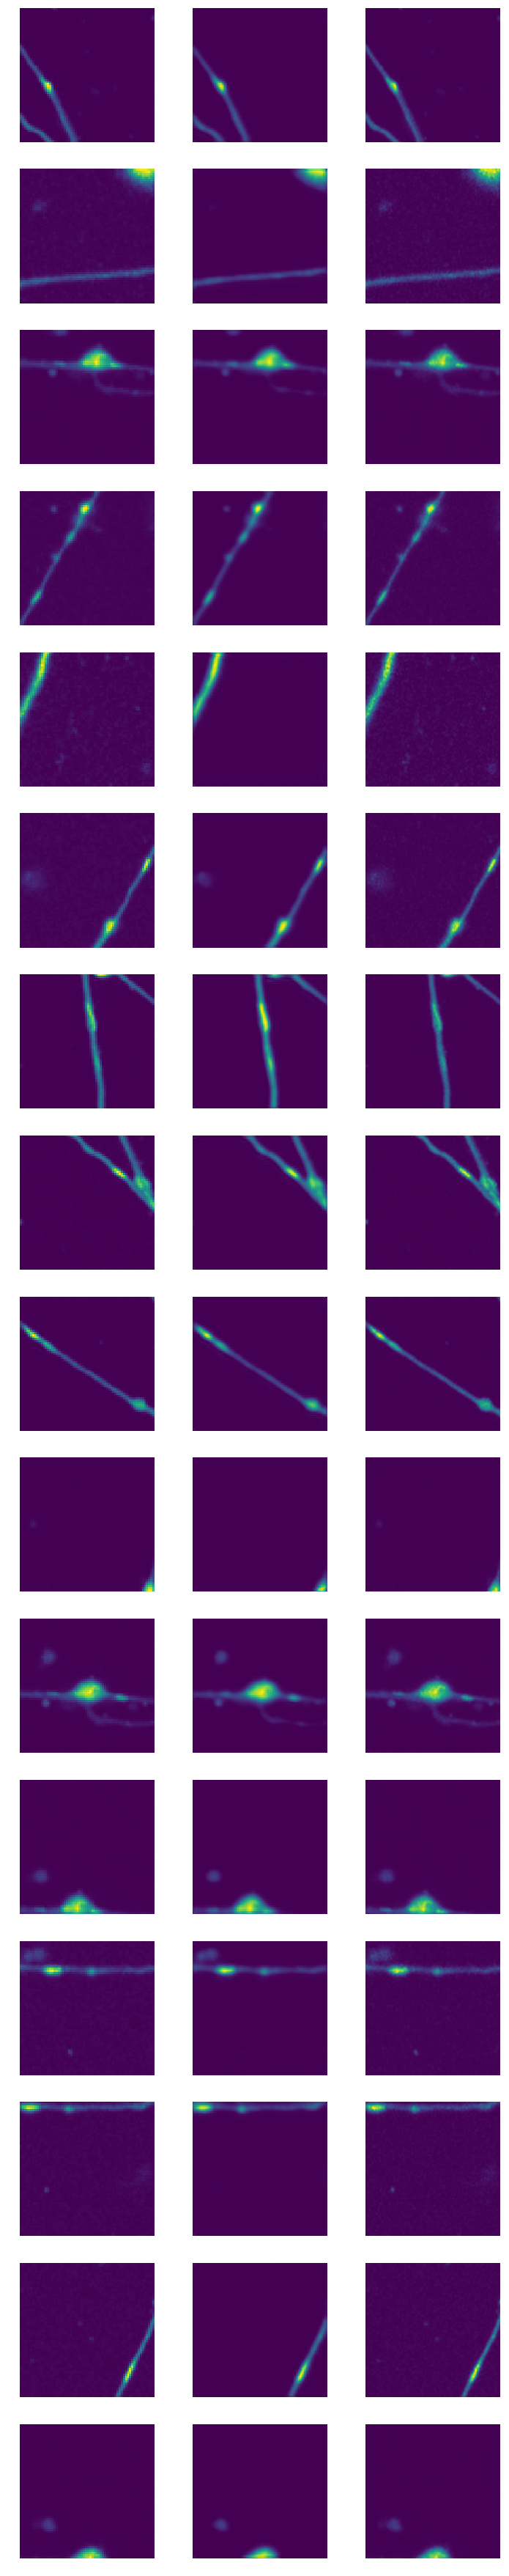

In [56]:
nrow = 3
axs = subplots(max(len(xs),nrow),3)
fs = (5,5)
for i, row_ax in enumerate(axs):
    xs[i].show(ax=row_ax[0], figsize=fs)
    preds[i].show(ax=row_ax[1], figsize=fs)
    ys[i].show(ax=row_ax[2], figsize=fs)

In [57]:
def image_from_tiles(learn, in_img, lr_sz=64, scale=4, pad=24):
    hr_sz = lr_sz * scale
    w, h = in_img.shape
    #print(w,h)
    in_tile = torch.zeros((lr_sz,lr_sz))
    out_img = torch.zeros((w*scale,h*scale))
    tile_sz = lr_sz - pad // scale
    #print(tile_sz)
    for x_tile in range(math.ceil(w/tile_sz)):
        for y_tile in range(math.ceil(h/tile_sz)):
            l_offset = pad // 4
            t_offset = pad // 4

            if x_tile == 0: l_offset = 0
            if y_tile == 0: t_offset = 0
            #print(l_offset, t_offset)

            x_start = x_tile*tile_sz - l_offset
            x_end = min(x_start+lr_sz, w)
            y_start = y_tile*tile_sz - t_offset
            y_end = min(y_start+lr_sz, h)
            #print("input: ", x_start, y_start, ",", x_end, y_end)
            in_tile[0:(x_end-x_start), 0:(y_end-y_start)] = in_img[x_start:x_end, y_start:y_end]
            out_tile,_,_ = learn.predict(Image(in_tile[None]))

            out_x_start = (4*(x_start+l_offset))
            out_x_end = (4*x_end)
            out_y_start = (4*(y_start+t_offset))
            out_y_end = (4*y_end)

            #print("out: ", out_x_start, out_y_start, ",", out_x_end, out_y_end)
            in_x_start = (4*l_offset)
            in_y_start = (4*t_offset)
            in_x_end = 4*(x_end-x_start)
            in_y_end = 4*(y_end-y_start)
            #print("tile: ",in_x_start, in_y_start, ",", in_x_end, in_y_end)

            out_img[out_x_start:out_x_end, out_y_start:out_y_end] = out_tile.data[0,
                                                                                  in_x_start:in_x_end, 
                                                                                  in_y_start:in_y_end]
    return out_img

In [11]:
lr_movies = list((test_path/'lr').iterdir())
hr_movies = list((test_path/'hr').iterdir())
valid_movies = list(valid_lr.iterdir())

In [12]:
valid_movies

[]

In [13]:
a_movie=lr_movies[0]

In [14]:
a_movie.stem

'MitoTracker Red FM 230x230 10min 01-Airyscan Processing-04'

In [26]:
import imageio

def cpz_to_movie(czi_in, out_movie='out.mp4'):
    with czifile.CziFile(czi_in) as czi_f:
        proc_axes, proc_shape = get_czi_shape_info(czi_f)
        channels = proc_shape['C'] 
        depths = proc_shape['Z']
        times = proc_shape['T']
        x,y = proc_shape['X'], proc_shape['Y']
        data = czi_f.asarray()
        origs = []
        for t in progress_bar(list(range(times))):
            idx = build_index(proc_axes, {'T': t, 'C': 0, 'Z':0, 'X':slice(0,x),'Y':slice(0,y)})
            img = data[idx].astype(np.float32)
            img -= img.min()
            img /= img.max()
            t_img = tensor(img)
            orig = (t_img[None]*255).cpu().numpy().astype(np.uint8)
            origs.append(orig)
        all_y = np.concatenate(origs)
        imageio.mimwrite(out_movie, all_y, fps=30, macro_block_size=None)
        
def save_movie(learn, czi_in, orig_out='orig.mp4', pred_out='pred.mp4'):
    with czifile.CziFile(czi_in) as czi_f:
        proc_axes, proc_shape = get_czi_shape_info(czi_f)
        channels = proc_shape['C'] 
        depths = proc_shape['Z']
        times = proc_shape['T']
        x,y = proc_shape['X'], proc_shape['Y']
        data = czi_f.asarray()
        preds = []
        origs = []
        for t in progress_bar(list(range(times))):
            idx = build_index(proc_axes, {'T': t, 'C': 0, 'Z':0, 'X':slice(0,x),'Y':slice(0,y)})
            img = data[idx].astype(np.float32)
            img -= img.min()
            img /= img.max()
            t_img = tensor(img)
            out_img = image_from_tiles(learn, t_img)
            
            pred = (out_img[None]*255).cpu().numpy().astype(np.uint8)
            preds.append(pred)
            orig = (t_img[None]*255).cpu().numpy().astype(np.uint8)
            origs.append(orig)
            
        all_y = np.concatenate(preds)
        imageio.mimwrite(pred_out, all_y, fps=30, macro_block_size=None)
        all_y = np.concatenate(origs)
        imageio.mimwrite(orig_out, all_y, fps=30, macro_block_size=None)

In [24]:
sz_lr = 64
scale,bs = 4,16
sz_hr = sz_lr*scale

learn = build_learner(model, bs, sz_lr, sz_hr, src, loss=loss, model_dir=path_models)

learn = learn.load('movies_1.0')

In [25]:
for movie in progress_bar(lr_movies):
    orig = f'{movie.stem}_orig.mp4'
    pred = f'{movie.stem}_pred.mp4'
    save_movie(learn, movie, orig_out=orig, pred_out=pred)
    break

In [31]:
for movie in progress_bar(hr_movies):
    out_movie = f'{movie.stem}.mp4'
    cpz_to_movie(movie, out_movie=out_movie)

for movie in progress_bar(lr_movies):
    out_movie = f'{movie.stem}.mp4'
    cpz_to_movie(movie, out_movie=out_movie)

In [29]:
lr_movies

[PosixPath('/DATA/WAMRI/salk/uri/movies/movie_test/lr/MitoTracker Red FM 230x230 10min 01-Airyscan Processing-04.czi'),
 PosixPath('/DATA/WAMRI/salk/uri/movies/movie_test/lr/MitoTracker Red FM 230x230 2min 02-Airyscan Processing-02.czi'),
 PosixPath('/DATA/WAMRI/salk/uri/movies/movie_test/lr/MitoTracker Red FM 230x230 2min 03-Airyscan Processing-03.czi'),
 PosixPath('/DATA/WAMRI/salk/uri/movies/movie_test/lr/MitoTracker Red FM 230x230 10min 02-Airyscan Processing-05.czi'),
 PosixPath('/DATA/WAMRI/salk/uri/movies/movie_test/lr/MitoTracker Red FM 230x230 2min 01-Airyscan Processing-01.czi'),
 PosixPath('/DATA/WAMRI/salk/uri/movies/movie_test/lr/MitoTracker Red FM 230x230 10min 03-Airyscan Processing-06.czi')]

In [30]:
hr_movies

[PosixPath('/DATA/WAMRI/salk/uri/movies/movie_test/hr/MitoTracker Red FM 920x920 2min 01-Airyscan Processing-07.czi'),
 PosixPath('/DATA/WAMRI/salk/uri/movies/movie_test/hr/MitoTracker Red FM 920x920 10min 03-Airyscan Processing-12.czi'),
 PosixPath('/DATA/WAMRI/salk/uri/movies/movie_test/hr/MitoTracker Red FM 920x920 2min 03-Airyscan Processing-09.czi'),
 PosixPath('/DATA/WAMRI/salk/uri/movies/movie_test/hr/MitoTracker Red FM 920x920 2min 02-Airyscan Processing-08.czi'),
 PosixPath('/DATA/WAMRI/salk/uri/movies/movie_test/hr/MitoTracker Red FM 920x920 10min 02-Airyscan Processing-11.czi'),
 PosixPath('/DATA/WAMRI/salk/uri/movies/movie_test/hr/MitoTracker Red FM 920x920 10min 01-Airyscan Processing-10.czi')]

In [34]:

for movie in progress_bar(list(valid_src.iterdir())):
    out_movie = f'{movie.stem}.mp4'
    cpz_to_movie(movie, out_movie=out_movie)

In [59]:
valid_lr = list(valid_lr.iterdir())

In [79]:
img = open_grayscale(valid_lr[0])
out_img = image_from_tiles(learn, img.data[0])
out = PIL.Image.fromarray((out_img*255).cpu().numpy().astype(np.uint8), mode='L')

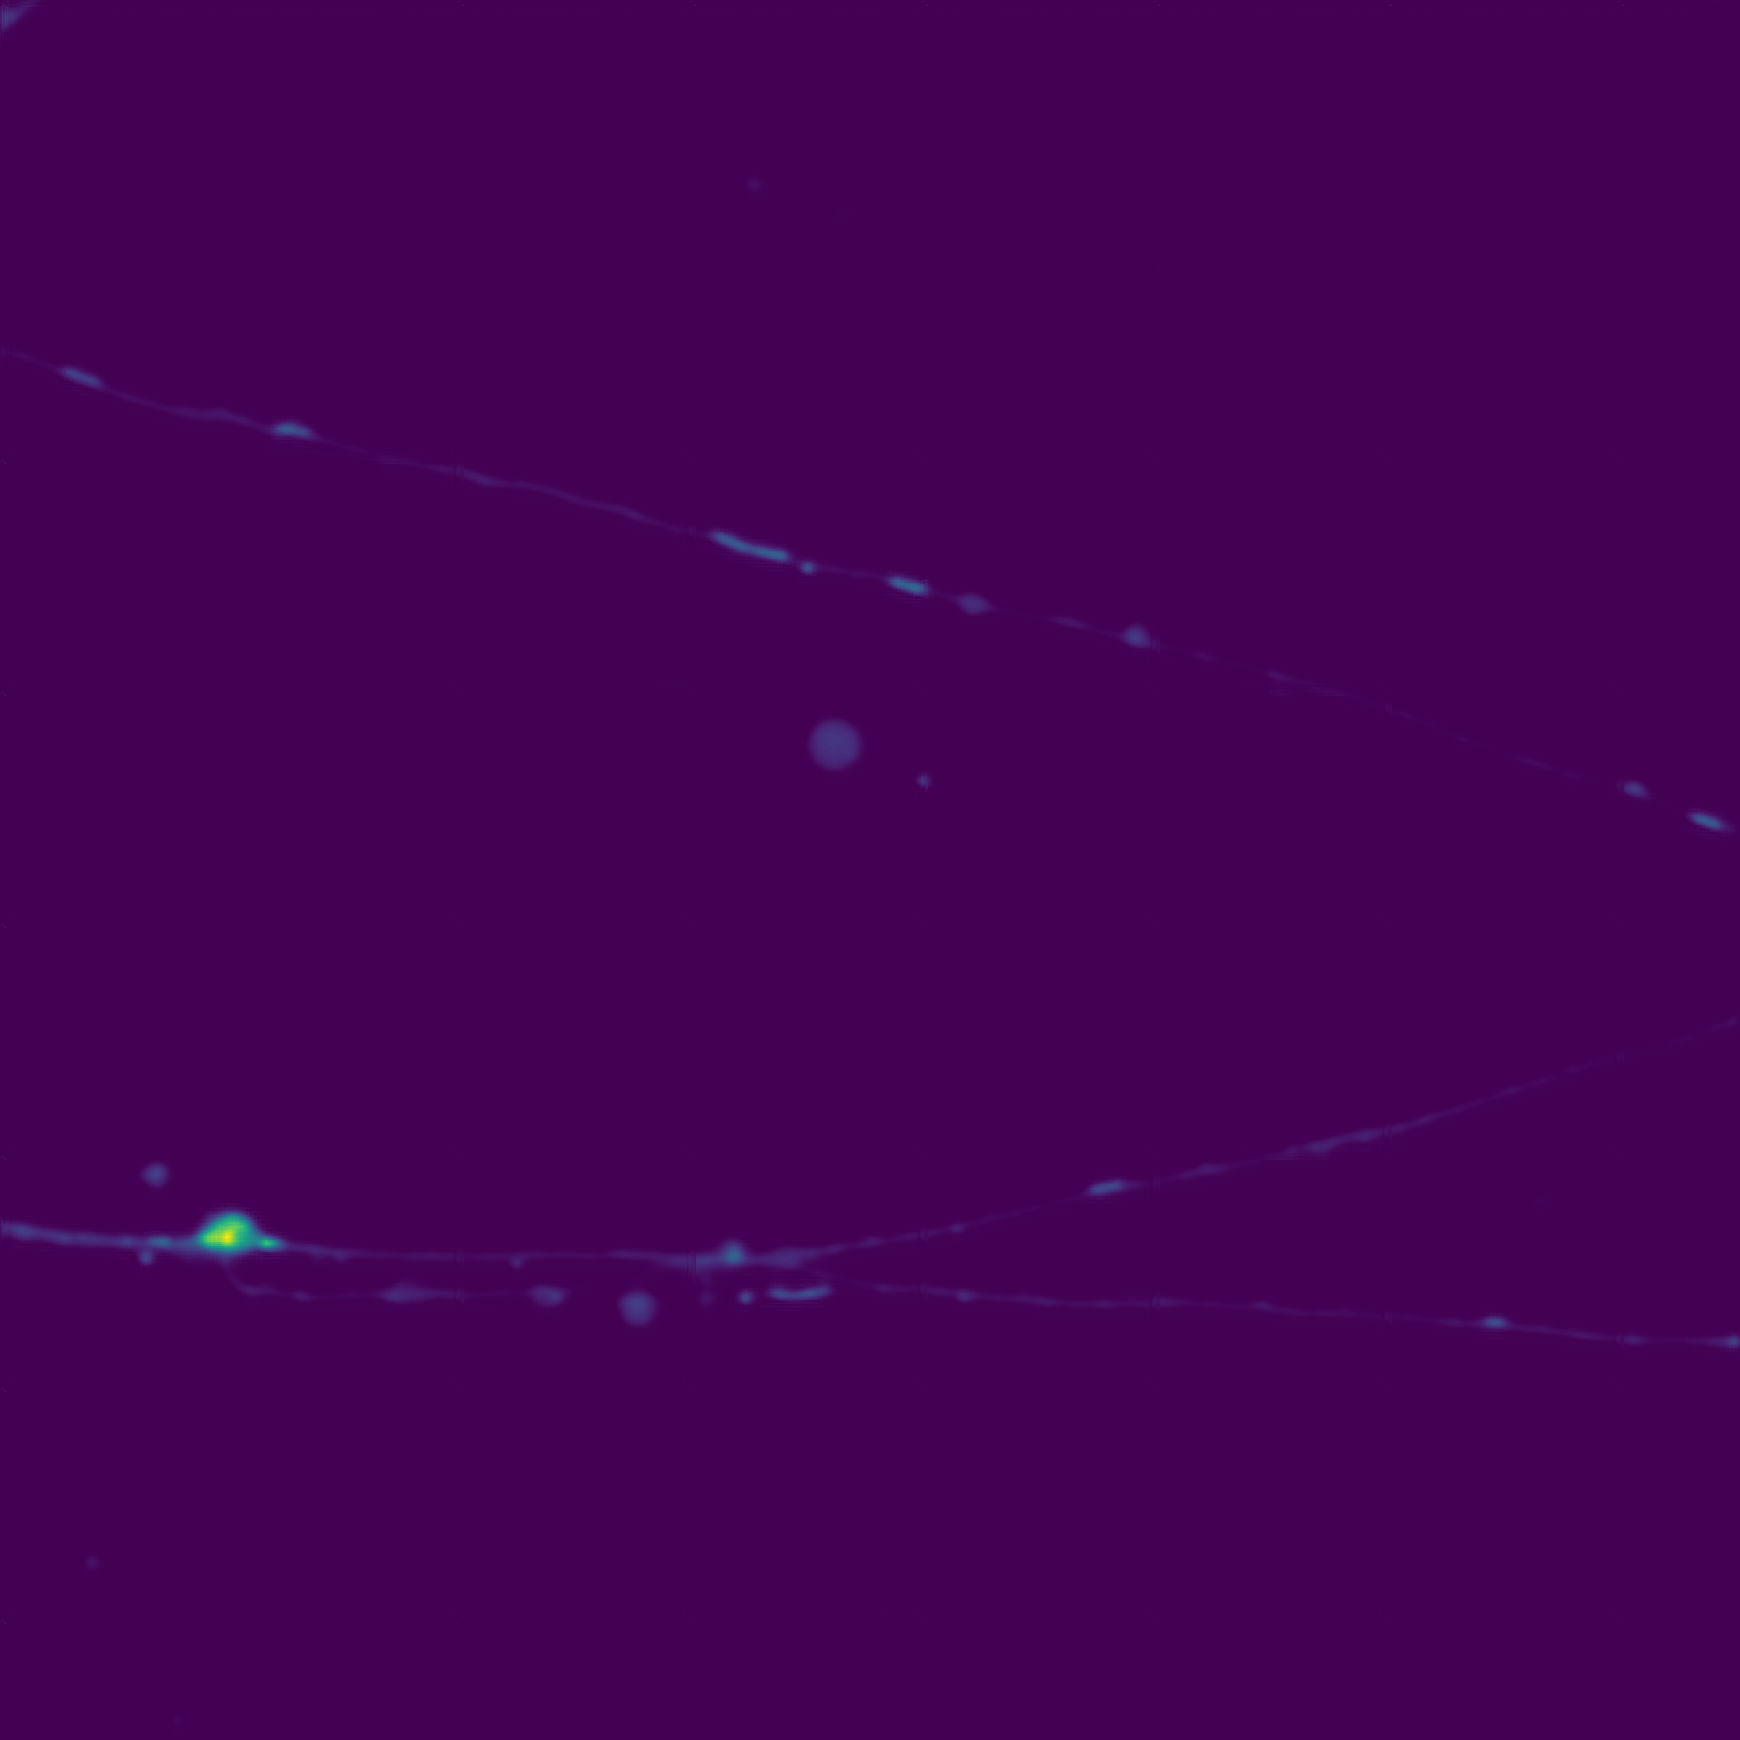

In [80]:
Image(out_img[None])

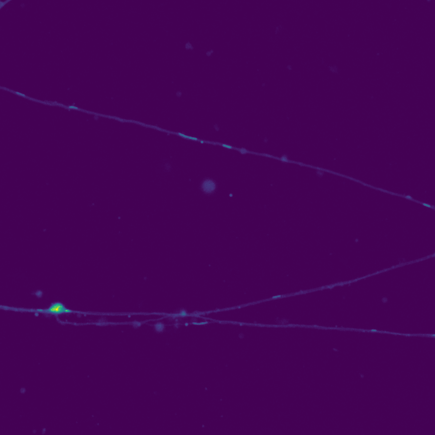

In [74]:
img